### Analyse de the performance of the network when applying the LRPcomposite

In [54]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= '0.20'

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.utils import class_weight

# TensorFlow ≥2.0 is required
import tensorflow_addons as tfa
import tensorflow as tf
assert tf.__version__ >= '2.0'

from tensorflow import keras
from tensorflow.keras import layers, regularizers

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Common imports
import os
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import dask
import datetime
import math
import pickle
import pathlib
import hashlib
import seaborn
dask.config.set({'array.slicing.split_large_chunks': False})

# To make this notebook's output stable across runs
np.random.seed(42)

# Config matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Dotenv
from dotenv import dotenv_values

# Custom utils
from utils.utils_data import *
from utils.utils_ml import *
from utils.utils_resnet import *
from utils.utils_plot import *
from utils.DNN_models import *
from utils.rank_relevances import *

Num GPUs Available:  1


In [22]:
import yaml
conf = yaml.safe_load(open("config.yaml"))
PRECIP_XTRM = 0.95 # Percentile (threshold) for the extremes
PRECIP_DATA = 'ERA5-low' 

In [16]:
# load data
# test samples
dg_train_X = np.array(xr.open_dataarray('tmp/data/dg_train_X.nc'))
dg_train_Y_xtrm = xr.open_dataarray('tmp/data/dg_train_Y_xtrm0.95th.nc')

In [17]:
dg_test_X = np.array(xr.open_dataarray('tmp/data/dg_test_X.nc'))
dg_test_Y = np.array(xr.open_dataarray('tmp/data/dg_test_Y.nc'))
dg_test_Y_xtrm = xr.open_dataarray('tmp/data/dg_test_Y_xtrm0.95th.nc')

In [18]:
# coordinates
lons_x = np.load('tmp/data/lons_y.npy')
lats_y = np.load('tmp/data/lats_y.npy')
# test-times
times = np.arange(np.datetime64('2016-01-01'), np.datetime64('2022-01-01'))
times = pd.to_datetime(times)

In [19]:
y_bool= dg_test_Y_xtrm

In [20]:
models = ['UNET1','UNET2','UNET3','UNET4']

In [45]:
# load weights
lrp_all = []
list_df = []
    
for m_id in models:
    lrp = np.load(f'tmp/LRP/lrpcomp_test_DNN_{m_id}.npy')
    lrp_all.append(lrp)
    localrel_avg, localrel_max  = getmap_localrel(lrp, conf['i_shape'], conf['varnames'], y_bool, lats_y, lons_x, times, icrop=3)
    rel_varmeans = localrel_avg.mean(axis=(0,1))
    df_sortedvars = [conf['varnames'][i] for i in np.argsort(rel_varmeans)[::-1]]
    df_sortval = [rel_varmeans[i] for i in np.argsort(rel_varmeans)[::-1]]
    data={'Model': m_id,'Variable' : df_sortedvars, 'Values' : df_sortval}
    df = pd.DataFrame(data)
    list_df.append(df)
    


In [96]:
df_all = pd.concat([list_df[3], list_df[2], list_df[1], list_df[0]])

In [97]:
dfpivot = df_all.pivot(columns='Model')

In [98]:
dfpivot

Variable                            Values                              
Model    UNET1   UNET2   UNET3   UNET4     UNET1     UNET2     UNET3     UNET4
0        RH700   RH700   RH700   U1000  0.088093  0.127502  0.169036  0.191723
1         U925    U925    U925   RH700  0.083050  0.120768  0.162419  0.190315
2         U300   V1000   U1000   V1000  0.082880  0.118949  0.161315  0.190024
3         V925   U1000   V1000    U925  0.082343  0.118613  0.160239  0.189629
4        U1000    U300    V925    V925  0.080043  0.117785  0.159424  0.181806
5        RH850    V925    U300    U300  0.079981  0.117264  0.157625  0.180020
6        V1000   RH850   RH850   RH850  0.079582  0.113771  0.151244  0.165982
7         V850    V850   RH500    V500  0.077133  0.109889  0.143146  0.165707
8         U850    U850   RH925    U850  0.075997  0.107751  0.141891  0.165301
9         V500    V500    U850    V850  0.073661  0.104302  0.141810  0.164190
10       RH925   RH500    V500   RH925  0.072714  0.103474  0.141291  0.156671
11      RH1000   RH925    V850    TPWC  0.072110  0.103286  0.141127  0.155703
12        U500  RH1000  RH1000   RH500  0.071604  0.103144  0.138761  0.155304
13        V700    V700    V300    V300  0.071581  0.101845  0.134972  0.155156
14       RH500    TPWC    TPWC    V700  0.070758  0.099718  0.134439  0.153581
15        U700    V300    V700  RH1000  0.070018  0.098836  0.133356  0.152986
16        TPWC    U700    U500    U500  0.069143  0.096087  0.127674  0.145699
17        V300    U500    U700    U700  0.067032  0.096037  0.125090  0.140595
18       T1000   RH300   RH300   RH300  0.062729  0.085233  0.111533  0.121348
19       RH300   T1000   T1000   T1000  0.059533  0.085004  0.109654  0.121212
20        Z925    Z925    Z925    Z925  0.057424  0.078974  0.100362  0.114745
21        Z700   Z1000   Z1000   Z1000  0.052640  0.075937  0.098491  0.110497
22       Z1000    Z850    Z850    Z850  0.052614  0.075350  0.096764  0.106780
23        Z850    Z700    Z700    Z700  0.052313  0.073047  0.094204  0.106698
24        T500    T925    T925    T925  0.051680  0.070305  0.091320  0.102101
25        T925    T500    T500    T500  0.051626  0.069222  0.090530  0.100223
26        Z300    Z500    T850    Z300  0.049008  0.068316  0.088481  0.097292
27        T850    Z300    Z500    Z500  0.048867  0.068075  0.088000  0.096623
28        Z500    T850    Z300    T850  0.048244  0.066202  0.086265  0.094932
29        T300    T300    T300    T300  0.047419  0.065541  0.085821  0.093272
30        T700    T700    T700    T700  0.043989  0.058415  0.076212  0.084676

In [79]:
# plot the outputs

In [99]:
df_all.head()

,Model,Variable,Values
0,UNET4,U1000,0.191723
1,UNET4,RH700,0.190315
2,UNET4,V1000,0.190024
3,UNET4,U925,0.189629
4,UNET4,V925,0.181806


Text(0.5, 0, '')

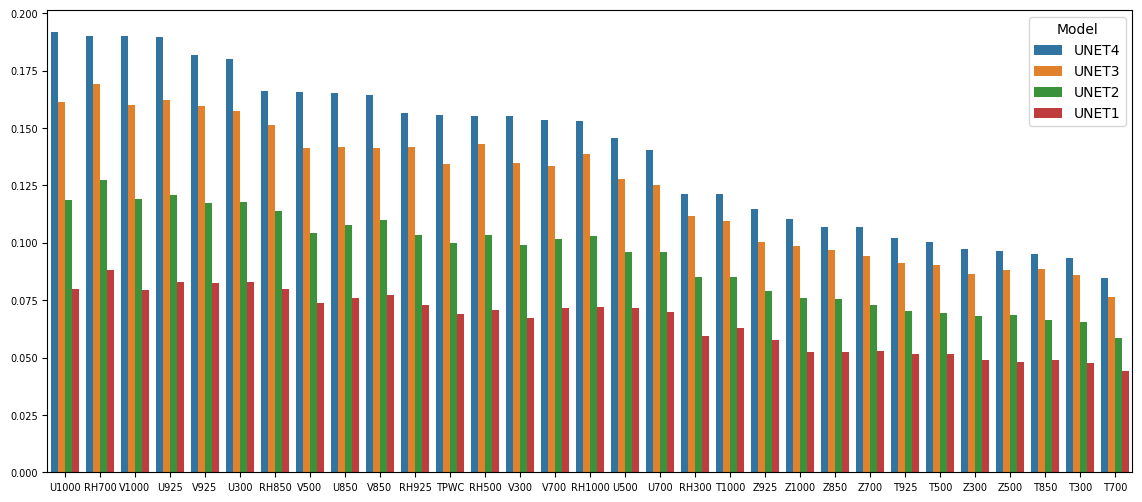

In [108]:
fig, ax = plt.subplots(figsize=(14,6))

sns.barplot(ax=ax, x = "Variable", y = "Values", hue = "Model", data = df_all)
plt.tick_params(labelsize=7)
#plt.show()
ax.set_ylabel(None)
ax.set_xlabel(None)

In [109]:
# save figure 
fname = 'Ranking_predictors_test_UNETs'
plt.savefig('figures/' + fname + '.pdf')

<Figure size 640x480 with 0 Axes>